# Arthur Henrique e Marcella Silveira #

O notebook abaixo trata do código utilizado para a segmentação das imagens de fundo de olho.

Para execução, é necessário ter a pasta Masks e Images que estão dentro da pasta ORIGA, disponível neste [link](https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets)

Com isso baixado, pode ser necessário ajustar os caminhos, porém uma vez feito, basta executar

In [10]:
#Ajuste os caminhos conforme necessário

image_dir = 'DatasetSeg/Images/'
mask_dir = 'DatasetSeg/Masks/'

#Demais parâmetros
input_shape = (128, 128, 3)
img_size = (128, 128)

In [12]:
#Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array

from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG19
from tensorflow.keras.regularizers import l2

### Carregar, normalizar e binarizar as máscaras e dados

In [3]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        # Caminhos das imagens e máscaras
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
        
        image = load_img(img_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        
        # Normalização
        images.append(img_to_array(image) / 255.0)  
        mask_array = img_to_array(mask)

        #binarizar
        masks.append((mask_array > 0).astype(np.float32))
    
    return np.array(images), np.array(masks)

### Construção da unet

In [8]:
def build_unet(backbone, input_shape, dropout_rate=0.3, l2_lambda=0.0001):
    #Foundation como encoder, removendo a fully connected do final

    if backbone == "resnet":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
        layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    elif backbone == "vgg19":
        base_model = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
        layer_names = ["block1_pool", "block2_pool", "block3_pool", "block4_pool"]
    elif backbone == "efficientnet":
        base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation"]
    else:
        raise ValueError("Backbone não suportada. Escolha 'resnet', 'vgg19' ou 'efficientnet'.")

    encoder_outputs = [base_model.get_layer(name).output for name in layer_names]
    # Bottleneck (última saída do encoder)
    bottleneck = base_model.output

    # Decoder - reconstruindo a segmentação
    up1 = UpSampling2D((2, 2))(bottleneck)
    up1 = concatenate([up1, encoder_outputs[-1]], axis=-1)
    conv1 = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(l2_lambda))(up1)

    up2 = UpSampling2D((2, 2))(conv1)
    up2 = concatenate([up2, encoder_outputs[-2]], axis=-1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(l2_lambda))(up2)

    up3 = UpSampling2D((2, 2))(conv2)
    up3 = concatenate([up3, encoder_outputs[-3]], axis=-1)
    conv3 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(l2_lambda))(up3)

    up4 = UpSampling2D((2, 2))(conv3)
    up4 = concatenate([up4, encoder_outputs[-4]], axis=-1)
    conv4 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(l2_lambda))(up4)

    up5 = UpSampling2D((2, 2))(conv4)  
    outputs = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(up5)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model



### Instanciação do modelo

In [5]:
# Criando o modelo com ResNet50 como encoder 
model_res = build_unet("resnet", input_shape)
model_vgg = build_unet("vgg19", input_shape)
model_eff = build_unet("efficientnet", input_shape)

In [6]:
model_res.summary() #Apenas para ver o modelo
model_vgg.summary() #Apenas para ver o modelo
model_eff.summary() #Apenas para ver o modelo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

### Compilando os modelos ###

Foi necessário definiri um calculo de IoU personalizado pois o nativa do keras só funciona para classificação multiclasse de 2 classes. Foi realizado apenas um classificação binária nesse caso

In [6]:
#IoU customizado para uma classe apenas (ajuda dos universitários nessa)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.05, tf.float32)  # Binariza a predição
    y_true = tf.cast(y_true, tf.float32)  # Garante que y_true é float

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)  # Retorna a média do batch

In [8]:
#Compilando os modelos
model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        iou_metric, #IoU
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ])

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        iou_metric, #IoU
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ])

model_eff.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        iou_metric, #IoU
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ])

### Separação dos dados e treino

In [9]:
images, masks = load_data(image_dir, mask_dir, img_size)

from sklearn.model_selection import train_test_split
#70% pra treino
train_images, temp_images, train_masks, temp_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

#30% para treino e validação
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)


#Treino
history_res = model_res.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=50,
    batch_size=8
)

history_vgg = model_vgg.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=50,
    batch_size=8
)

history_eff = model_eff.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=50,
    batch_size=8
)


model_res.save('unet_model_based_resnet.h5')
model_vgg.save('unet_model_based_vgg.h5')
model_eff.save_weights('unet_model_weights_eff.h5')  # Salva apenas os pesos, pois na effnet tava dando problema, não importa o formato utilizado

Epoch 1/50
57/57 [==============================] - 12s 79ms/step - loss: 0.1715 - iou_metric: 0.4311 - precision: 0.5269 - recall: 0.5823 - auc: 0.9362 - val_loss: 1.0676 - val_iou_metric: 3.1959e-09 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4999
Epoch 2/50
57/57 [==============================] - 2s 44ms/step - loss: 0.0846 - iou_metric: 0.6820 - precision: 0.8822 - recall: 0.8779 - auc: 0.9979 - val_loss: 0.3079 - val_iou_metric: 3.2386e-09 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4995
Epoch 3/50
57/57 [==============================] - 3s 46ms/step - loss: 0.0643 - iou_metric: 0.7434 - precision: 0.9162 - recall: 0.9093 - auc: 0.9993 - val_loss: 0.3134 - val_iou_metric: 3.2386e-09 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4995
Epoch 4/50
57/57 [==============================] - 3s 46ms/step - loss: 0.0520 - iou_metric: 0.7493 - precision: 0.9212 - recall: 0.9217 - auc: 0.9995 - val_loss: 0.2802 - val_iou_metri

### Testes e gráficos de métricas

In [10]:
# Avaliação no conjunto de teste
test_results_res = model_res.evaluate(test_images, test_masks, batch_size=8)
test_results_vgg = model_vgg.evaluate(test_images, test_masks, batch_size=8)
test_results_eff = model_eff.evaluate(test_images, test_masks, batch_size=8)



# Exibir os resultados
print("\nMétricas no conjunto de teste ResNet-50:")
for metric_name, metric_value in zip(model_res.metrics_names, test_results_res):
    print(f"{metric_name}: {metric_value:.4f}")

print("\nMétricas no conjunto de teste VGG19:")
for metric_name, metric_value in zip(model_vgg.metrics_names, test_results_vgg):
    print(f"{metric_name}: {metric_value:.4f}")

print("\nMétricas no conjunto de teste EfficientNet-B0:")
for metric_name, metric_value in zip(model_eff.metrics_names, test_results_eff):
    print(f"{metric_name}: {metric_value:.4f}")


13/13 [==============================] - 0s 26ms/step - loss: 0.0557 - iou_metric: 0.6752 - precision_2: 0.9941 - recall_2: 0.5472 - auc_2: 0.8882

Métricas no conjunto de teste ResNet-50:
loss: 0.0087
iou_metric: 0.8390
precision: 0.9424
recall: 0.9299
auc: 0.9977

Métricas no conjunto de teste VGG19:
loss: 0.0185
iou_metric: 0.8258
precision_1: 0.9624
recall_1: 0.8746
auc_1: 0.9983

Métricas no conjunto de teste EfficientNet-B0:
loss: 0.0557
iou_metric: 0.6752
precision_2: 0.9941
recall_2: 0.5472
auc_2: 0.8882


### Plots dos gráficos ###

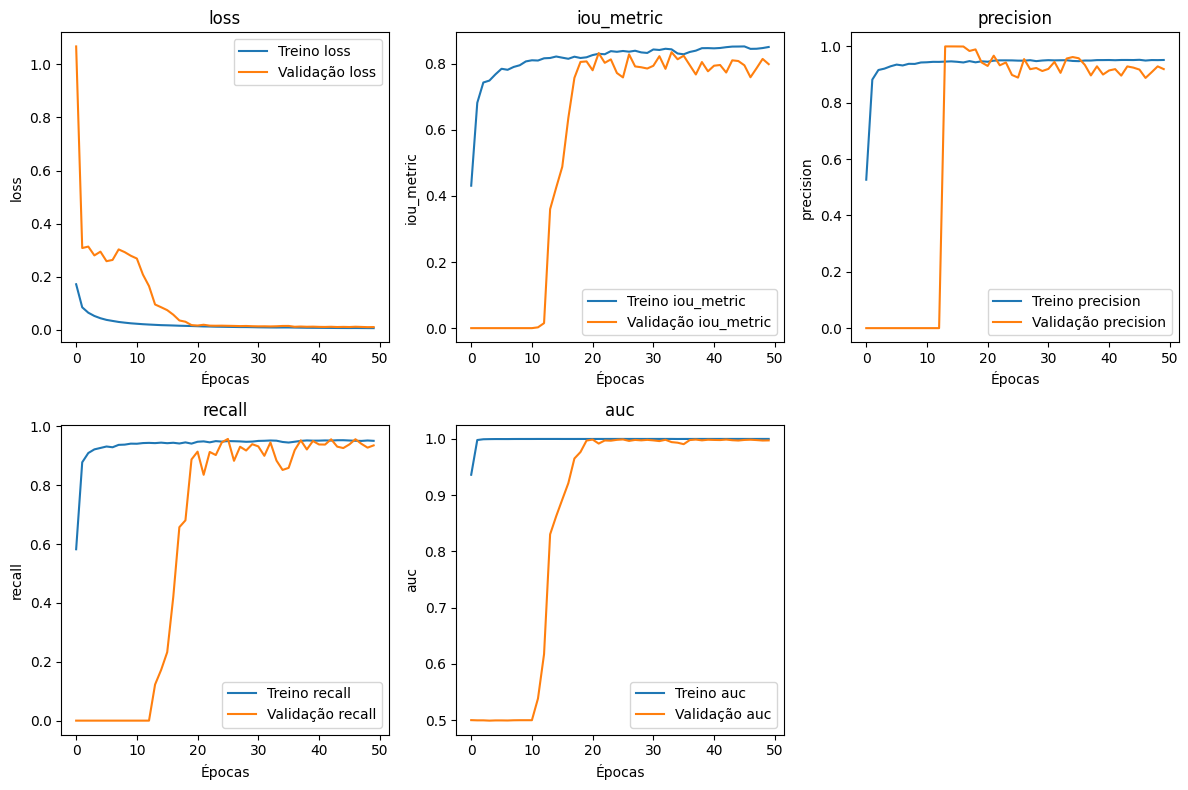

In [11]:
import matplotlib.pyplot as plt

# Extrair os valores das métricas
history_res = history_res.history

# Definir métricas a serem plotadas
metrics_res = ["loss", "iou_metric", "precision", "recall", "auc"]

# Criar os gráficos
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics_res):
    plt.subplot(2, 3, i + 1)  # Criar subgráficos
    plt.plot(history_res[metric], label=f'Treino {metric}')
    plt.plot(history_res[f'val_{metric}'], label=f'Validação {metric}')
    plt.xlabel("Épocas")
    plt.ylabel(metric)
    plt.legend()
    plt.title(metric)

plt.tight_layout()
plt.show()


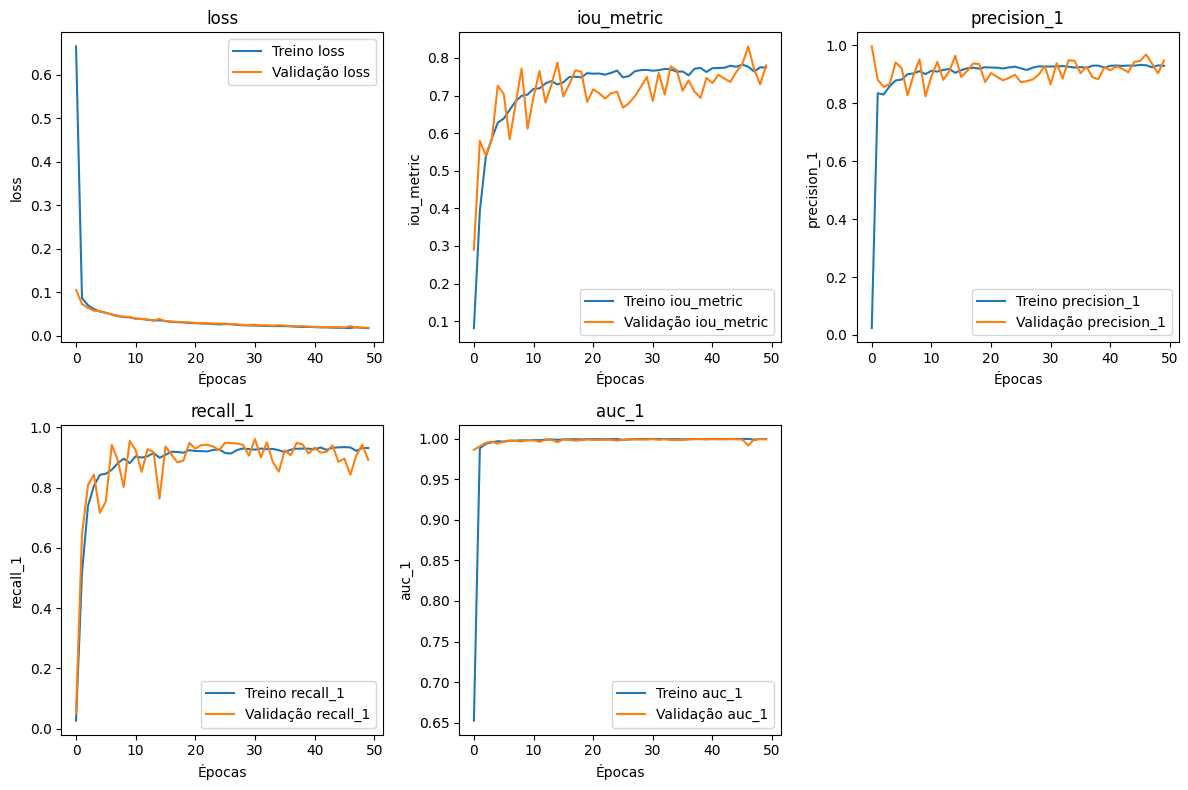

In [ ]:
# Extrair os valores das métricas
history_vgg = history_vgg.history

# Definir métricas a serem plotadas
metrics_vgg = ["loss", "iou_metric", "precision_1", "recall_1", "auc_1"]

# Criar os gráficos
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics_vgg):
    plt.subplot(2, 3, i + 1)  # Criar subgráficos
    plt.plot(history_vgg[metric], label=f'Treino {metric}')
    plt.plot(history_vgg[f'val_{metric}'], label=f'Validação {metric}')
    plt.xlabel("Épocas")
    plt.ylabel(metric)
    plt.legend()
    plt.title(metric)

plt.tight_layout()
plt.show()

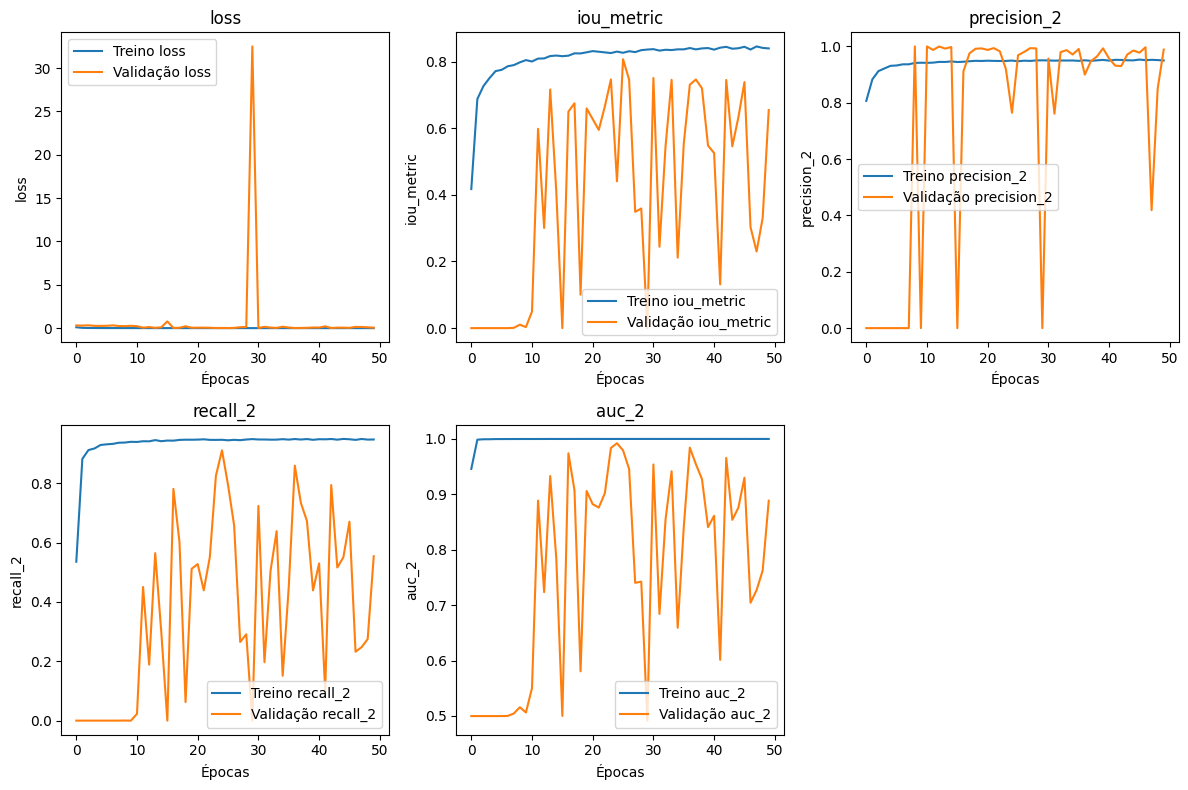

In [20]:
# Extrair os valores das métricas
history_eff = history_eff.history

# Definir métricas a serem plotadas
metrics_eff = ["loss", "iou_metric", "precision_2", "recall_2", "auc_2"]

# Criar os gráficos
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics_eff):
    plt.subplot(2, 3, i + 1)  # Criar subgráficos
    plt.plot(history_eff[metric], label=f'Treino {metric}')
    plt.plot(history_eff[f'val_{metric}'], label=f'Validação {metric}')
    plt.xlabel("Épocas")
    plt.ylabel(metric)
    plt.legend()
    plt.title(metric)

plt.tight_layout()
plt.show()

## Verificação nos dados da SMDG

Nessa etapa, o modelo será aplicado na prática nas imagens do SMDG-19, de forma a procurar verificar se há diferenças visuais notórias.

Nessa etapa, é necessário ter a pasta do SMDG no local do código, disponível no [link](https://www.kaggle.com/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/data)

In [ ]:
input_directory = 'SMDG\image-full-fundus\image-full-fundus'

#Caso necessário alterar os caminhos finais, alterar aqui
output_directory_res = 'SMDG\image_segment_results_resnet'
output_directory_vgg = 'SMDG\image_segment_results_vgg'
output_directory_eff = 'SMDG\image_segment_results_eff'

In [2]:
#Imports
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [15]:

# Função para carregar e processar uma imagem individual
def preprocess_single_image(image_path, img_size=(128, 128)):
    image = load_img(image_path, target_size=img_size)
    image = img_to_array(image) / 255.0  # Normalizar entre 0 e 1
    return np.expand_dims(image, axis=0)  # Expandir dimensão para (1, H, W, C)

# Função para segmentar e salvar imagens
def segment_and_save_images(input_dir, output_dir, model, img_size=(128, 128), threshold=0.05):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(input_dir, filename)
            processed_image = preprocess_single_image(image_path, img_size)

            # Prever a máscara
            predicted_mask = model.predict(processed_image)[0]

            # Gerar a máscara binária
            binary_mask = (predicted_mask.squeeze() > threshold).astype(np.uint8)

            # Carregar a imagem original sem redimensionar
            original_image = img_to_array(load_img(image_path))

            # Redimensionar a máscara binária para a forma original da imagem
            binary_mask_resized = resize(binary_mask, original_image.shape[:2], preserve_range=True).astype(np.uint8)
            binary_mask_resized = np.stack([binary_mask_resized] * 3, axis=-1)


            indices = np.where(binary_mask_resized[..., 0] > 0.1)
            if indices[0].size == 0 or indices[1].size == 0:
                print(f"Imagem {filename} não contém pixels segmentados acima do limiar. Ignorando...")
                continue

            min_row, max_row = np.min(indices[0]), np.max(indices[0])
            min_col, max_col = np.min(indices[1]), np.max(indices[1])

            center_row, center_col = (min_row + max_row) // 2, (min_col + max_col) // 2
            half_size = max(max_row - min_row, max_col - min_col) // 2

            start_row = max(center_row - half_size, 0)
            end_row = min(center_row + half_size, original_image.shape[0])
            start_col = max(center_col - half_size, 0)
            end_col = min(center_col + half_size, original_image.shape[1])

            cropped_image = original_image[start_row:end_row, start_col:end_col]

            standardized_image = resize(cropped_image, img_size, preserve_range=True)

            output_path = os.path.join(output_dir, filename)
            plt.imsave(output_path, standardized_image.astype(np.uint8))

            print(f"Imagem {filename} processada e salva em {output_path}")


In [13]:
model_res = load_model('unet_model_based_resnet.h5', custom_objects={'iou_metric': iou_metric})
model_vgg = load_model('unet_model_based_vgg.h5', custom_objects={'iou_metric': iou_metric})

#Para a effnet já que os pesos foram salvos apenas, é necessário reconstruir a rede
model_eff = build_unet('efficientnet', input_shape)
model_eff.load_weights('unet_model_weights_eff.h5')

In [16]:
print("\n\nProcessando com resnet\n\n")
segment_and_save_images(input_directory, output_directory_res, model_res)

print("\n\nProcessando com vgg\n\n")
segment_and_save_images(input_directory, output_directory_vgg, model_vgg)

print("\n\nProcessando com efficientnet\n\n")
segment_and_save_images(input_directory, output_directory_eff, model_eff)



Processando com resnet


1/1 [==============================] - 1s 985ms/step
Imagem BEH-1.png processada e salva em SMDG\image_segment_results_resnet\BEH-1.png
1/1 [==============================] - 0s 17ms/step
Imagem BEH-10.png processada e salva em SMDG\image_segment_results_resnet\BEH-10.png
1/1 [==============================] - 0s 17ms/step
Imagem BEH-100.png processada e salva em SMDG\image_segment_results_resnet\BEH-100.png
1/1 [==============================] - 0s 37ms/step
Imagem BEH-101.png processada e salva em SMDG\image_segment_results_resnet\BEH-101.png
1/1 [==============================] - 0s 20ms/step
Imagem BEH-102.png processada e salva em SMDG\image_segment_results_resnet\BEH-102.png
1/1 [==============================] - 0s 18ms/step
Imagem BEH-103.png processada e salva em SMDG\image_segment_results_resnet\BEH-103.png
1/1 [==============================] - 0s 17ms/step
Imagem BEH-104.png processada e salva em SMDG\image_segment_results_resnet\BEH-104.png
1/1 [